In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import scipy.interpolate as interpolate
import math
import pandas as pd
from scipy.signal import argrelextrema
from scipy import signal
from scipy import stats
from scipy import interpolate

In [2]:
%matplotlib notebook

In [99]:
class ModelDumps:
    
    def __init__(self,filelist):
        
        TimeArray = []
        NameArray = []
        GridData = []
        filelist = np.sort(filelist)
        
        for f in filelist:
            
            # Generate the time array:
            TimeFile = open(f)
            TimeData = TimeFile.readline()
            Time = TimeData
            Time = Time.strip().split()
            Time = np.float(Time[1])
            TimeArray.append(Time)
            
            TempNames = TimeFile.readline().split()
            
            TimeFile.close()
            # generate the column name array:
            if len(NameArray) < 1:
                NameArray =  TempNames
            else:
                if len(TempNames) != len(NameArray):
                    raise ValueError("Different number of column names!")
                for i in range(len(NameArray)):
                    if NameArray[i] != TempNames[i]:
                        raise ValueError("Column names don't match")
                        

            data = pd.read_csv(f,skiprows=2,na_values='-',delimiter='\s+')
            data.to_numpy
            GridData.append(data)
            
        GridData = np.stack(GridData,axis=0)
        
        self.times = np.array(TimeArray)
        self.names = NameArray
        self.nameDict = {}
        for i in range(len(self.names)):
            self.nameDict[self.names[i]] = i
        self.grid = GridData
        
        # calculate the period using autocorrelation:
    
        seriesTime = 20 * 86400 # always calculate over last 20 days of the time series
        periodResolution = 0.0001 * 24 * 3600

        nsteps = np.int(seriesTime / periodResolution)#
        #np.int(10**np.floor(np.log10(seriesTime/periodResolution)))
        nsteps = np.min((10**5, nsteps))

        #print(seriesTime,periodResolution,nsteps,nsteps/4)
        maxTime = self.times[-1]
        minTime = maxTime - seriesTime

        StableTime = self.times[self.times > minTime]
        Ur0_short = self.grid[:, -1, 20]
        Ur0_short = Ur0_short[self.times > minTime]

        # minTime = greater of minTime and StableTime[0]

        minTime = np.max((StableTime[0],minTime))

        InterpedTime = np.linspace(minTime, maxTime, nsteps)

        Interped = interpolate.interp1d(StableTime, Ur0_short)
        InterpedUr0 = Interped(InterpedTime[1:])

        Correlation = np.correlate(InterpedUr0,InterpedUr0,mode='full')

        timestep = (np.max(StableTime) - np.min(StableTime)) / nsteps
        #print(timestep)
        #print(timestep * 70 / 86400 / 4)
        peaks = signal.argrelextrema(Correlation[nsteps:nsteps+np.int(nsteps/4)],np.greater)

        period  = np.mean(np.diff(peaks))*timestep/86400
        PeriodError = np.std(np.diff(peaks))*timestep/86400
    
        self.period = period
        self.pererr = PeriodError
        
        
    def plotTime(self,zone=-1, column="U0[cm/s](21)"):
        ax = plt.gca()
        
        colNum = self.nameDict[column]
        plt.plot(self.times/86400,self.grid[:, zone, colNum])
        
    def plotRadial(self,column,time=0):
        
        ax = plt.gca()
        colNum = self.nameDict[column]
        plt.plot(self.grid[time,:,colNum])
        
    def plotPhased(self,zone,column):
    
        ax = plt.gca()
        colNum = self.nameDict[column]
        SortedIndices = np.argsort(self.times)
        plt.plot((self.times[SortedIndices]%self.period)/self.period,self.grid[SortedIndices,zone,colNum])

In [100]:
fileList = glob.glob("HighVRun/Profiles/*pro.txt")
fileList = np.sort(fileList)

#%prun # used for timing, but I've got it fast enough now.
HighVData = ModelDumps(fileList)


864 864


In [95]:
def autocorrtest(dump):
    # calculate the period using autocorrelation:
    
    seriesTime = 80 * 86400 # always calculate over last 20 days of the time series.
    periodResolution = 0.0001 * 24 * 3600

    nsteps = np.int(seriesTime / periodResolution)#
    #np.int(10**np.floor(np.log10(seriesTime/periodResolution)))
    nsteps = np.min((10**5, nsteps))

    #print(seriesTime,periodResolution,nsteps,nsteps/4)
    maxTime = dump.times[-1]
    minTime = maxTime - seriesTime

    StableTime = dump.times[dump.times > minTime]
    Ur0_short = dump.grid[:, -2, 20]
    Ur0_short = Ur0_short[dump.times > minTime]
    
    # minTime = greater of minTime and StableTime[0]
    
    minTime = np.max((StableTime[0],minTime))
    
    

    InterpedTime = np.linspace(minTime, maxTime, nsteps)
    print(len(StableTime), len(Ur0_short))

    Interped = interpolate.interp1d(StableTime, Ur0_short)
    InterpedUr0 = Interped(InterpedTime[1:])

    Correlation = np.correlate(InterpedUr0,InterpedUr0,mode='full')

    timestep = (np.max(StableTime) - np.min(StableTime)) / nsteps
    #print(timestep)
    #print(timestep * 70 / 86400 / 4)
    peaks = signal.argrelextrema(Correlation[nsteps:nsteps+np.int(nsteps/4)],np.greater)

    period  = np.mean(np.diff(peaks))*timestep/86400
    PeriodError = np.std(np.diff(peaks))*timestep/86400
    print(period)
    
    column = "U0[cm/s](21)"
    zone = -2
    plt.gca()
    colNum = dump.nameDict[column]
    SortedIndices = np.argsort(dump.times)
    
    plt.plot(((dump.times[SortedIndices]/86400)%dump.period)/dump.period,dump.grid[SortedIndices,zone,colNum],'.')

<IPython.core.display.Javascript object>


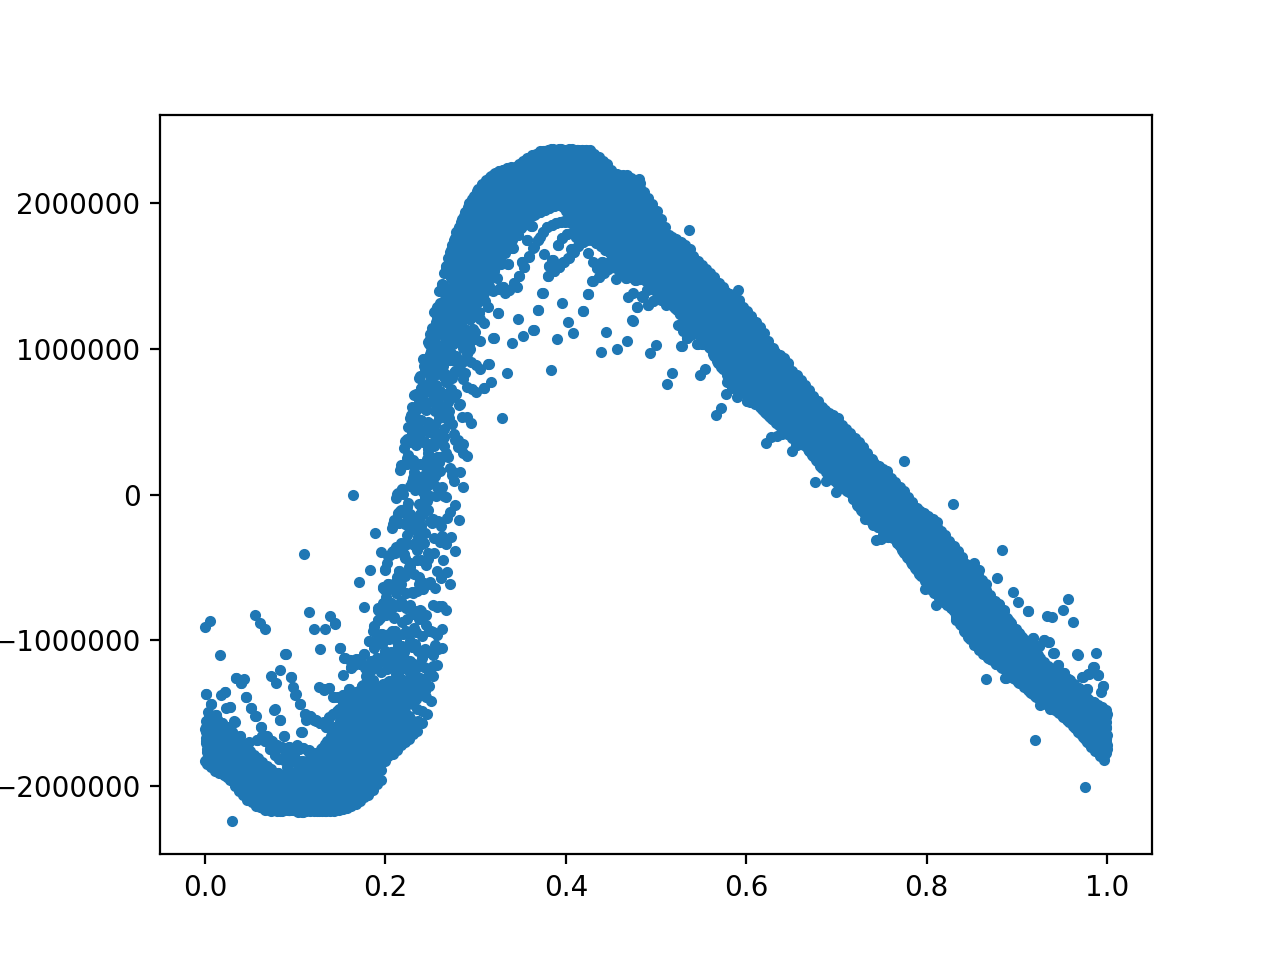

3453 3453
0.42248820673834725
171.81622277623723


In [101]:
plt.figure()
autocorrtest(HighVData)
print(HighVData.times[-1]/86400)

<IPython.core.display.Javascript object>


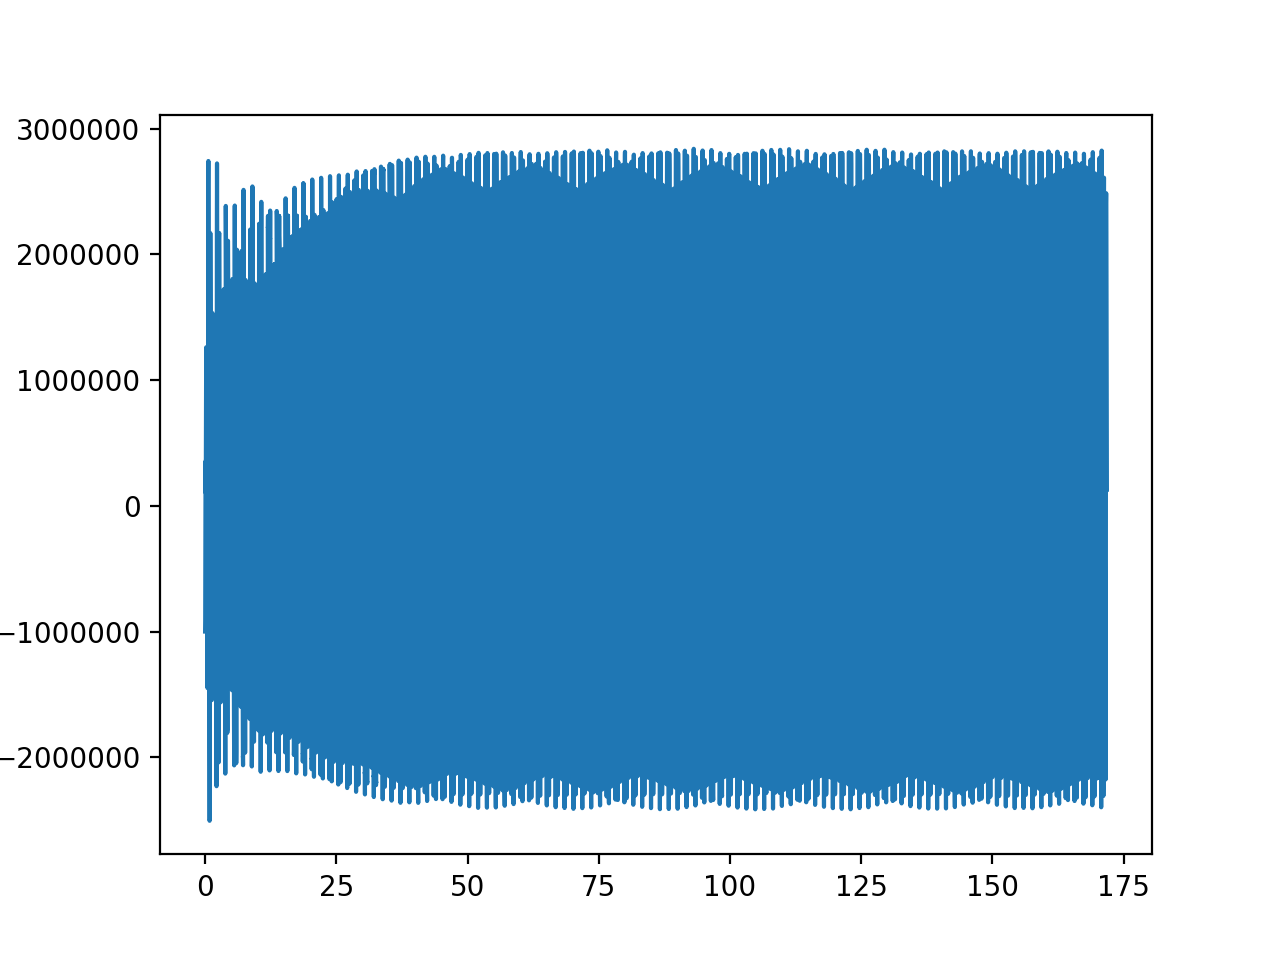

<IPython.core.display.Javascript object>


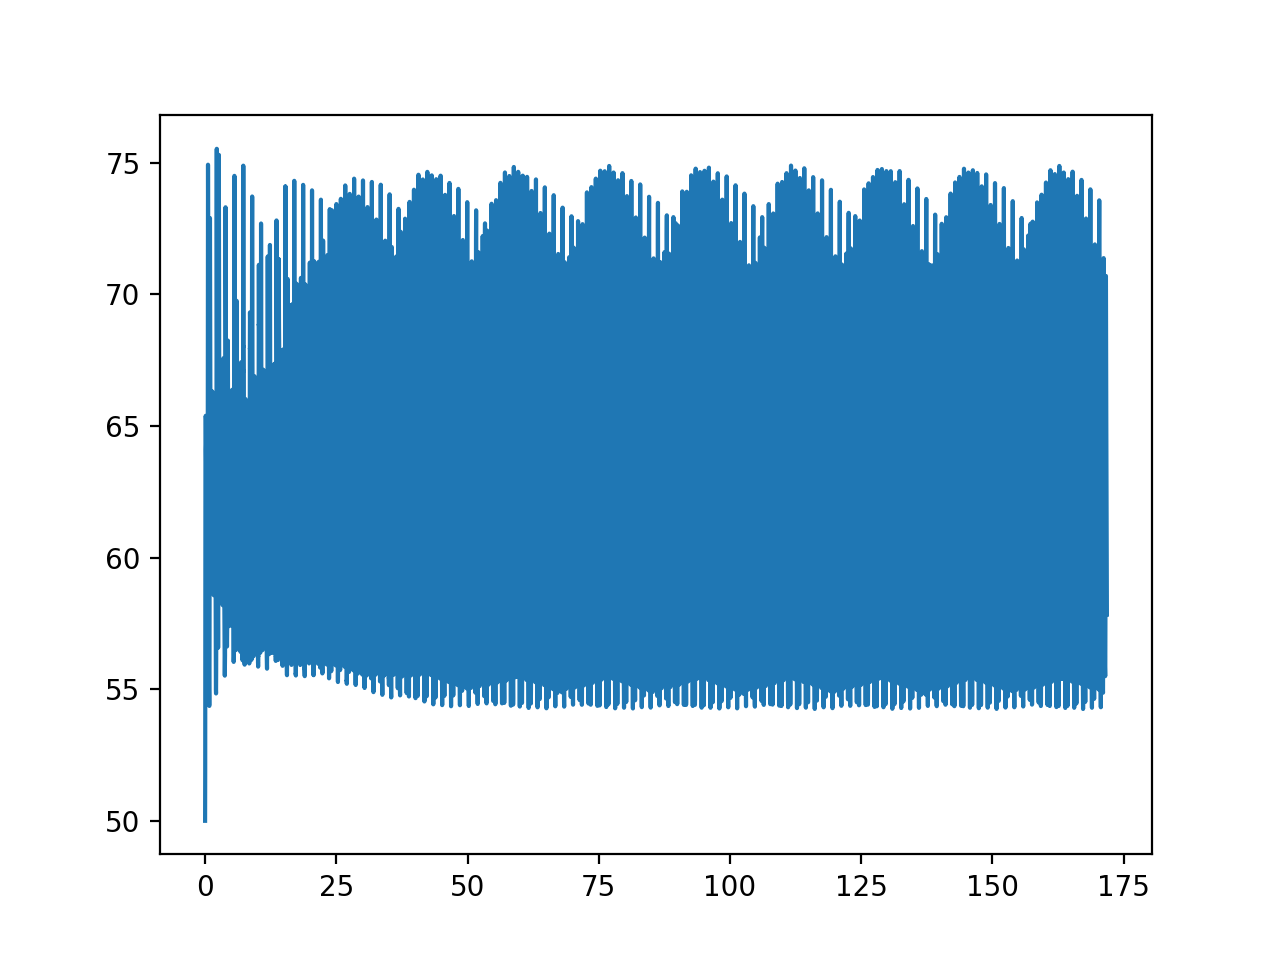

In [10]:
plt.figure()
HighVData.plotTime(zone=-1, column="U0[cm/s](21)")
plt.figure()
HighVData.plotTime(zone=-1, column="L_rd_im1half[L_sun](60)")

<IPython.core.display.Javascript object>


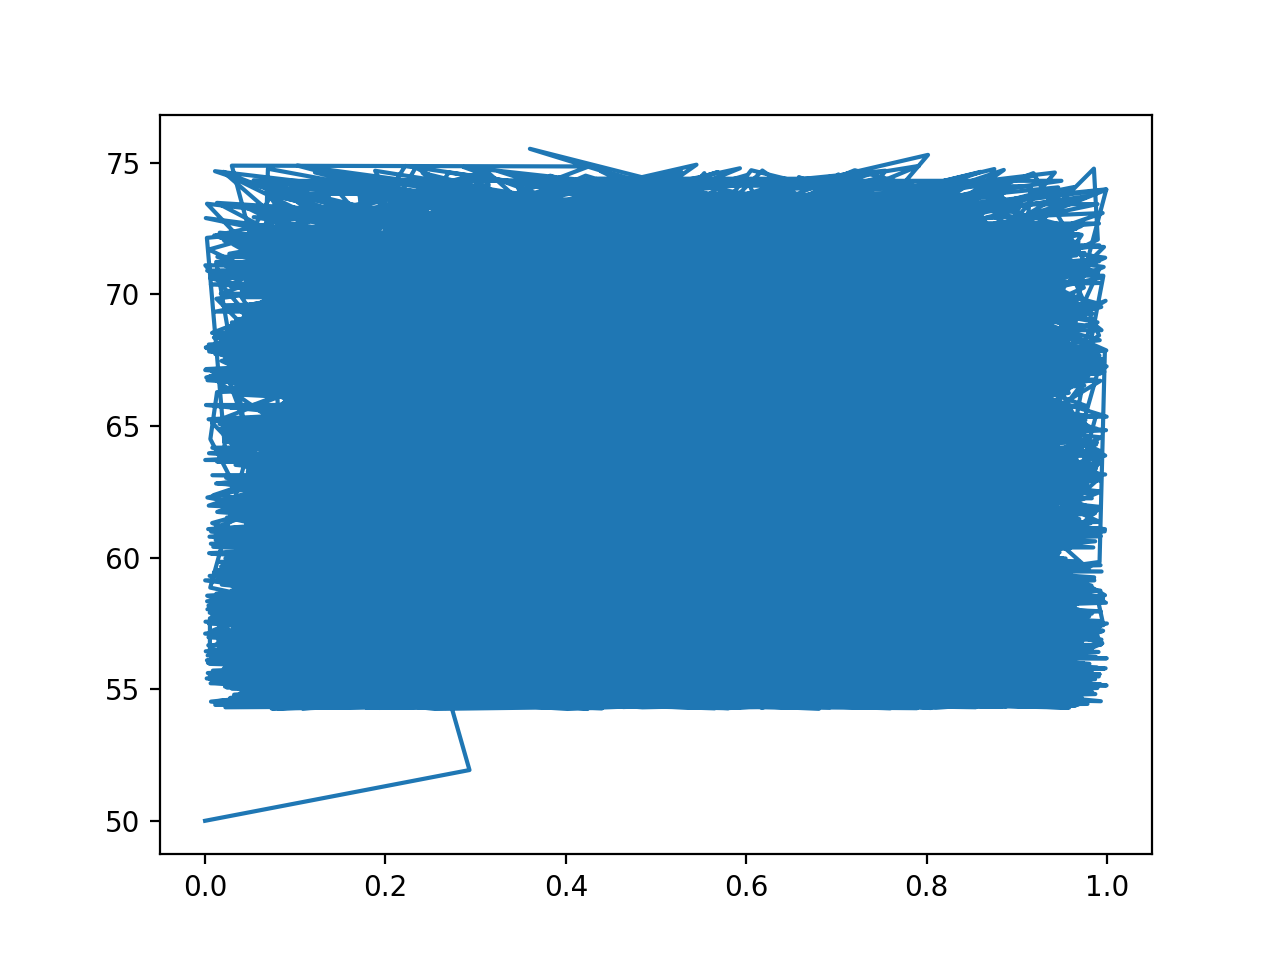

In [61]:
plt.figure()
HighVData.plotPhased(-1,'L_rd_im1half[L_sun](60)')

In [ ]:
fileList = glob.glob("HighVRun/Profiles/*pro.txt")
#fileList = glob.glob("HighVRun/*pro.txt")
fileList = np.sort(fileList)
AllData = []
#TimeArray = []
# load these into a np array
for f in fileList[1:5]:
    #print(AllData.ndim)
    data = pd.read_csv(f,skiprows=2,na_values='-',delimiter='\s+')
    data.to_numpy
    #print(data.shape)
    AllData.append(data)

print(AllData[0].shape)
    #data = np.genfromtxt(f,skip_header=2)
#    TimeFile = open(f)
#    TimeData = TimeFile.readlines()
#    Time = TimeData[0]
#    Time = Time.strip().split()
#    Time = np.float(Time[1])
##    TimeArray.append(Time)
#    Model = ModelDump(Time,data)
#    AllData.append(Model)
#    #    if AllData.ndim == 1:
#       AllData = Model
#    elif AllData.ndim == 2:
#        AllData = np.stack((AllData,Model),axis=2)
#    else:
#        AllData.append(Model)

    
        #print(AllData.shape)
#print(AllData.shape)
# try defining a class for time + profile data

In [ ]:
# Need to reload the data and add the time array to the saved output
AllData.tofile("RRLOutput.bin")

In [ ]:
AllData = np.fromfile("RRLOutput.bin")
AllData = np.reshape(AllData,(174,80,8611))

In [ ]:
# Set a segment of the time array to use to find the period
tmin = 200 * 86400
Ur0 = AllData[0].data[20,:]
#Ur0_short = Ur0[TimeArray>tmin]
StableTime = AllData[0].time#[AllData[0].time>tmin]#TimeArray[TimeArray>tmin]
print(StableTime)

In [ ]:
# try autocorrelation to get the period instead
# interpolated time step should be roughly equal to desired resolution in period.
seriesTime = np.max(StableTime)-np.min(StableTime)
periodResolution = 0.0001 * 24 * 3600
nsteps = np.int(10**np.floor(np.log10(seriesTime/periodResolution)))
nsteps = np.min((10**5, nsteps))
print(seriesTime,periodResolution,nsteps,nsteps/4)

InterpedTime = np.linspace(np.min(StableTime),np.max(StableTime),nsteps)
Interped = interpolate.interp1d(StableTime,Ur0_short)
InterpedUr0 = Interped(InterpedTime)
Correlation = np.correlate(InterpedUr0,InterpedUr0,mode='full')

timestep = (np.max(StableTime) - np.min(StableTime)) / nsteps
print(timestep)
#print(timestep * 70 / 86400 / 4)
peaks = signal.argrelextrema(Correlation[nsteps:nsteps+np.int(nsteps/4)],np.greater)

period  = np.mean(np.diff(peaks))*timestep/86400
print(period)
plt.figure()
plt.plot(Correlation,'-d')
CenterIndex = np.argwhere(Correlation==np.max(Correlation))
maxvalue = np.max(Correlation)
secondmaxvalue = np.max(Correlation[Correlation != maxvalue])
MaxIndices = np.argwhere(Correlation == secondmaxvalue)

In [ ]:
PhasedTime = ((StableTime/86400)%period)/period
SortedIndices = np.argsort(PhasedTime)


In [ ]:
plt.figure()
p2 = period#0.4225
plt.plot(PhasedTime[SortedIndices],Ur0_short[SortedIndices],'.')

In [ ]:
# Temperature vs. phase in zone n
n = 50
Tavg = AllData[50,49,:] # T_ave(K)
plt.figure()
plt.plot((StableTime/86400)%period,Tavg[TimeArray>tmin],'.')

In [ ]:
# work in zone n vs. phase
dW = 0.5 * (AllData[n,6,:] - AllData[n-1,6,:]) * (AllData[n,66,:] - AllData[n-1,66,:]) \
* AllData[n,3,:]
# delta rho (<D>(g/cm^3) * delta P (P_ave(dynes/cm^2) * dM_r))
plt.figure()
plt.plot(dW)
#plt.plot((StableTime/86400)%period,dW[TimeArray>tmin],'.')

In [ ]:
# get max of Vr-V0 vs time
Vr = AllData[:,13,:] # U_ave_im1half  
# Note that here I'm currently using the horizontally averaged radial velocity, but I should
# probably do this using the 2D files so I get the full range of values.  
V0 = AllData[:,20,:] # U0
Vdiff = np.abs(Vr - V0)
MaxVLoc = np.nanargmax(Vdiff,axis=0)
MaxVdiff = np.nanmax(Vdiff,axis=0)

In [ ]:
plt.figure()
plt.plot(MaxVdiff/100/1000)
plt.ylabel("$|V_r - V_0|$ (km/s)")
plt.xlabel("Time (d)")

In [ ]:
# get max of Vtheta-V0 vs time
Vtheta = AllData[:,21,:] # V_ave
#V0 = AllData[:,20,:] # U0
Vthetadiff = np.abs(Vtheta - V0)
MaxVthetaLoc = np.nanargmax(Vthetadiff,axis=0)
MaxVthetadiff = np.nanmax(Vthetadiff,axis=0)

In [ ]:
plt.figure()
plt.plot(MaxVthetadiff/100/1000)
plt.ylabel("|$V_{\theta} - V_0$| (km/s)")
plt.xlabel("Time (d)")

In [ ]:
# get max of T - <T> vs time
T = AllData[:,50,:] # Using Tmax at the moment, but I think I might actually need 2D data for this one
Tbar = AllData[:,49,:] # T_ave
Tdiff = np.abs(T - Tbar)
MaxTLoc = np.nanargmax(Tdiff,axis=0)
MaxTdiff = np.nanmax(Tdiff,axis=0)

In [ ]:
plt.figure()
plt.plot(MaxTdiff/100/1000)
plt.ylabel("T - <T> (K)")
plt.xlabel("Time (d)")